In [ ]:
# # Stable Baselines only supports tensorflow 1.x for now
# %tensorflow_version 1.x
# !apt install swig cmake libopenmpi-dev zlib1g-dev
# !pip install stable-baselines[mpi]==2.10.0 box2d box2d-kengz
!pip install stable_baselines3

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
!ls /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
'My Drive'


In [ ]:
### Set the right directory
### Must change to right directory to run!
%cd /gdrive/My\ Drive/Colab\ Notebooks/RL/citylearn/CityLearn

/gdrive/My Drive/Colab Notebooks/RL/citylearn/CityLearn


In [ ]:
import os
import gym
import numpy as np
from stable_baselines3 import SAC
from stable_baselines3.sac.policies import MlpPolicy as MlpPolicy_SAC
from citylearn import  CityLearn
import matplotlib.pyplot as plt
from pathlib import Path
import time
# from stable_baselines.common.callbacks import BaseCallback
# from stable_baselines.bench import Monitor
# from stable_baselines.results_plotter import load_results, ts2xy
import pandas as pd
import seaborn as sns
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise

In [ ]:
# Create log dir
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)
# Central agent controlling one of the buildings using the OpenAI Stable Baselines
climate_zone = 2
data_path = Path("data/Climate_Zone_"+str(climate_zone))
building_attributes = data_path / 'building_attributes.json'
weather_file = data_path / 'weather_data.csv'
solar_profile = data_path / 'solar_generation_1kW.csv'
building_state_actions = 'buildings_state_action_space.json'
building_ids = ['Building_1','Building_2','Building_3','Building_4',\
                'Building_5','Building_6','Building_7','Building_8','Building_9']
objective_function = ['ramping','1-load_factor','average_daily_peak','peak_demand','net_electricity_consumption','quadratic']
### I have made change in citylearn.py
### I made the change that when reward is NONE it will use power of 1 reward function
### if reward is given 2 then it will use power of 2 reward function
### if reward is given 3 then it will use power of 3 reward function
env = CityLearn(data_path, building_attributes, weather_file, solar_profile, \
                building_ids, buildings_states_actions = building_state_actions,\
                cost_function = objective_function, central_agent = True, \
                verbose = 1, reward = None)

In [ ]:
### action noise
# the noise objects for DDPG
# n_actions = env.action_space.shape[-1]
# param_noise = None
# action_noise = OrnsteinUhlenbeckActionNoise(mean=np.zeros(n_actions), sigma=float(0.5) * np.ones(n_actions))

### stable baseline look at epoch
model = SAC(MlpPolicy_SAC, env, verbose=0, learning_rate=0.01, gamma=0.99, \
            tau=3e-4, batch_size=2048, learning_starts=8759)
start = time.time()
overall_cost = []
diff_parm_actor= []
diff_parm_critic = []
for epoch in range(10):
  # 1st data
  # 1st data + 1st data
  # w1 
  #model = SAC(MlpPolicy_SAC, env, verbose=0, learning_rate=0.01, gamma=0.99, tau=3e-4, batch_size=2048, learning_starts=8759)
  model.learn(total_timesteps=8760*(epoch+1), log_interval=1000)
  if epoch == 0:
    prev_actor = model.actor.parameters_to_vector()
    prev_critic = model.critic.parameters_to_vector()
  else:
    dist = np.linalg.norm(prev_actor-model.actor.parameters_to_vector())
    diff_parm_actor.append(dist)
    prev_actor = model.actor.parameters_to_vector()
    dist = np.linalg.norm(prev_critic-model.critic.parameters_to_vector())
    diff_parm_critic.append(dist)
    prev_critic = model.critic.parameters_to_vector()
  print(time.time()-start)
  obs = env.reset()
  dones = False
  counter = []
  while dones==False:
      action, _states = model.predict(obs)
      obs, rewards, dones, info = env.step(action)
      counter.append(rewards)
  cost_2 = env.cost().copy()
  cost_2['reward_function'] = "power_one"
  cost_2['epoch'] = epoch
  cost_2
  overall_cost.append(cost_2)
  print (cost_2)

Cumulated reward: 1390874.7541000037
4.525115489959717
Cumulated reward: 1378166.7142000047
{'ramping': 0.95921063, '1-load_factor': 1.0681204005010698, 'average_daily_peak': 1.0569938, 'peak_demand': 1.1935021, 'net_electricity_consumption': 1.0333234, 'quadratic': 1.1584309, 'total': 1.0782635477504428, 'reward_function': 'power_one', 'epoch': 0}
Cumulated reward: 1391241.0326000052
Cumulated reward: 1387587.1348999958
152.83774995803833
Cumulated reward: 1394722.1013999952
{'ramping': 0.8795926, '1-load_factor': 1.060666396275534, 'average_daily_peak': 1.0534776, 'peak_demand': 1.2549496, 'net_electricity_consumption': 1.0457363, 'quadratic': 1.1768328, 'total': 1.0785425527319932, 'reward_function': 'power_one', 'epoch': 1}
Cumulated reward: 1390866.860000001
Cumulated reward: 1387334.3258999956
Cumulated reward: 1387334.4887999997
417.1968140602112
Cumulated reward: 1386465.3244999947
{'ramping': 0.88234395, '1-load_factor': 1.0654197452847542, 'average_daily_peak': 1.0515366, 'pe

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


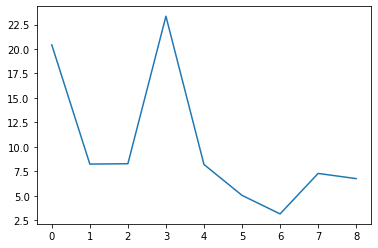

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


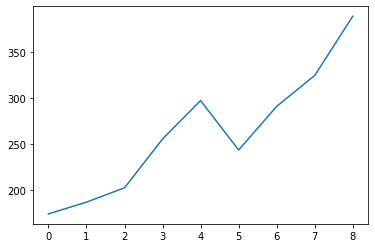

In [ ]:
#range = range(9)
sns.lineplot(range(9),diff_parm_actor)
plt.show()
sns.lineplot(range(9),diff_parm_critic)
plt.show()

In [ ]:
diff_parm_critic

[173.81573,
 186.58743,
 202.13945,
 255.20428,
 296.89822,
 243.2296,
 290.61432,
 324.20706,
 388.48816]

In [ ]:
# Create log dir
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)
# Central agent controlling one of the buildings using the OpenAI Stable Baselines
climate_zone = 1
data_path = Path("data/Climate_Zone_"+str(climate_zone))
building_attributes = data_path / 'building_attributes.json'
weather_file = data_path / 'weather_data.csv'
solar_profile = data_path / 'solar_generation_1kW.csv'
building_state_actions = 'buildings_state_action_space.json'
building_ids = ['Building_1','Building_2','Building_3','Building_4',\
                'Building_5','Building_6','Building_7','Building_8','Building_9']
objective_function = ['ramping','1-load_factor','average_daily_peak','peak_demand','net_electricity_consumption','quadratic']
env = CityLearn(data_path, building_attributes, weather_file, solar_profile, \
                building_ids, buildings_states_actions = building_state_actions,\
                cost_function = objective_function, central_agent = True, \
                verbose = 1, reward = 2)

In [ ]:
### action noise
# the noise objects for DDPG
# n_actions = env.action_space.shape[-1]
# param_noise = None
# action_noise = OrnsteinUhlenbeckActionNoise(mean=np.zeros(n_actions), sigma=float(0.5) * np.ones(n_actions))

### stable baseline look at epoch
model = SAC(MlpPolicy_SAC, env, verbose=0, learning_rate=0.01, gamma=0.99, \
            tau=3e-4, batch_size=2048, learning_starts=8759)
start = time.time()
overall_cost = []
diff_parm_actor= []
diff_parm_critic = []
for epoch in range(10):
  # 1st data
  # 1st data + 1st data
  # w1 
  #model = SAC(MlpPolicy_SAC, env, verbose=0, learning_rate=0.01, gamma=0.99, tau=3e-4, batch_size=2048, learning_starts=8759)
  model.learn(total_timesteps=8760*(epoch+1), log_interval=1000)
  if epoch == 0:
    prev_actor = model.actor.parameters_to_vector()
    prev_critic = model.critic.parameters_to_vector()
  else:
    dist = np.linalg.norm(prev_actor-model.actor.parameters_to_vector())
    diff_parm_actor.append(dist)
    print (dist)
    prev_actor = model.actor.parameters_to_vector()
    dist = np.linalg.norm(prev_critic-model.critic.parameters_to_vector())
    diff_parm_critic.append(dist)
    print (dist)
    prev_critic = model.critic.parameters_to_vector()
  print(time.time()-start)
  obs = env.reset()
  dones = False
  counter = []
  while dones==False:
      action, _states = model.predict(obs)
      obs, rewards, dones, info = env.step(action)
      counter.append(rewards)
  cost_2 = env.cost().copy()
  cost_2['reward_function'] = "power_one"
  cost_2['epoch'] = epoch
  cost_2
  overall_cost.append(cost_2)
  print (cost_2)

Cumulated reward: 377932029.03753656
4.767673492431641
Cumulated reward: 371530905.2737266
{'ramping': 0.99942386, '1-load_factor': 1.041601991845772, 'average_daily_peak': 1.0566111, 'peak_demand': 1.1906152, 'net_electricity_consumption': 1.0336752, 'quadratic': 1.1557149, 'total': 1.0796070258143222, 'reward_function': 'power_one', 'epoch': 0}
Cumulated reward: 378853471.8255852
Cumulated reward: 384596417.8803803
156.89842891693115
Cumulated reward: 393414667.47867936
{'ramping': 0.82540506, '1-load_factor': 1.0381893281786885, 'average_daily_peak': 1.0282862, 'peak_demand': 1.5966171, 'net_electricity_consumption': 1.0713938, 'quadratic': 1.2237884, 'total': 1.130613323129701, 'reward_function': 'power_one', 'epoch': 1}
Cumulated reward: 379147576.5634603
Cumulated reward: 393414667.47867936
Cumulated reward: 393414667.47867936
428.0675582885742
Cumulated reward: 393414667.47867936
{'ramping': 0.82540506, '1-load_factor': 1.0381893281786885, 'average_daily_peak': 1.0282862, 'peak_

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


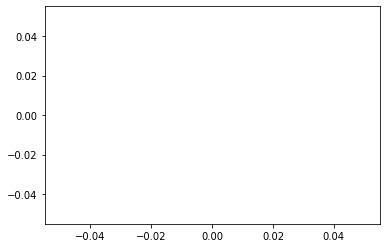

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


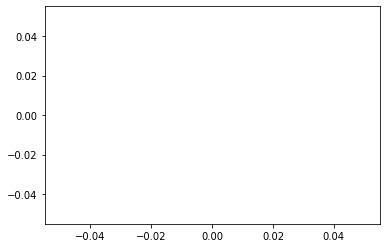

In [ ]:
#range = range(9)
sns.lineplot(range(9),diff_parm_actor)
plt.show()
sns.lineplot(range(9),diff_parm_critic)
plt.show()

In [ ]:
# Create log dir
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)
# Central agent controlling one of the buildings using the OpenAI Stable Baselines
climate_zone = 1
data_path = Path("data/Climate_Zone_"+str(climate_zone))
building_attributes = data_path / 'building_attributes.json'
weather_file = data_path / 'weather_data.csv'
solar_profile = data_path / 'solar_generation_1kW.csv'
building_state_actions = 'buildings_state_action_space.json'
building_ids = ['Building_1','Building_2','Building_3','Building_4',\
                'Building_5','Building_6','Building_7','Building_8','Building_9']
objective_function = ['ramping','1-load_factor','average_daily_peak','peak_demand','net_electricity_consumption','quadratic']
env = CityLearn(data_path, building_attributes, weather_file, solar_profile, \
                building_ids, buildings_states_actions = building_state_actions,\
                cost_function = objective_function, central_agent = True, \
                verbose = 1, reward = 3)

In [ ]:
### action noise
# the noise objects for DDPG
# n_actions = env.action_space.shape[-1]
# param_noise = None
# action_noise = OrnsteinUhlenbeckActionNoise(mean=np.zeros(n_actions), sigma=float(0.5) * np.ones(n_actions))

### stable baseline look at epoch
model = SAC(MlpPolicy_SAC, env, verbose=0, learning_rate=0.01, gamma=0.99, \
            tau=3e-4, batch_size=2048, learning_starts=8759)
start = time.time()
diff_parm_actor= []
diff_parm_critic = []
for epoch in range(10):
  # 1st data
  # 1st data + 1st data
  # w1 
  #model = SAC(MlpPolicy_SAC, env, verbose=0, learning_rate=0.01, gamma=0.99, tau=3e-4, batch_size=2048, learning_starts=8759)
  model.learn(total_timesteps=8760*(epoch+1), log_interval=1000)
  if epoch == 0:
    prev_actor = model.actor.parameters_to_vector()
    prev_critic = model.critic.parameters_to_vector()
  else:
    dist = np.linalg.norm(prev_actor-model.actor.parameters_to_vector())
    print (dist)
    diff_parm_actor.append(dist)
    prev_actor = model.actor.parameters_to_vector()
    dist = np.linalg.norm(prev_critic-model.critic.parameters_to_vector())
    print (dist)
    diff_parm_critic.append(dist)
    prev_critic = model.critic.parameters_to_vector()
  print(time.time()-start)
  obs = env.reset()
  dones = False
  counter = []
  while dones==False:
      action, _states = model.predict(obs)
      obs, rewards, dones, info = env.step(action)
      counter.append(rewards)
  cost_2 = env.cost().copy()
  cost_2['reward_function'] = "power_one"
  cost_2['epoch'] = epoch
  cost_2
  overall_cost.append(cost_2)
  print (cost_2)

Cumulated reward: 113568122327.86398
4.671783685684204
Cumulated reward: 111726903989.85123
{'ramping': 1.0656136, '1-load_factor': 1.0708299218817516, 'average_daily_peak': 1.063261, 'peak_demand': 1.2327261, 'net_electricity_consumption': 1.0349321, 'quadratic': 1.1570436, 'total': 1.1040677318838563, 'reward_function': 'power_one', 'epoch': 0}
Cumulated reward: 114003970275.78014
Cumulated reward: 116153084843.67102
152.617595911026
Cumulated reward: 119985974498.46863
{'ramping': 0.82540506, '1-load_factor': 1.0381893281786885, 'average_daily_peak': 1.0282862, 'peak_demand': 1.5966171, 'net_electricity_consumption': 1.0713938, 'quadratic': 1.2237884, 'total': 1.130613323129701, 'reward_function': 'power_one', 'epoch': 1}
Cumulated reward: 113468347483.20499
Cumulated reward: 119985974498.46863
Cumulated reward: 119985974498.46863
416.2159037590027
Cumulated reward: 119985974498.46863
{'ramping': 0.82540506, '1-load_factor': 1.0381893281786885, 'average_daily_peak': 1.0282862, 'peak

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


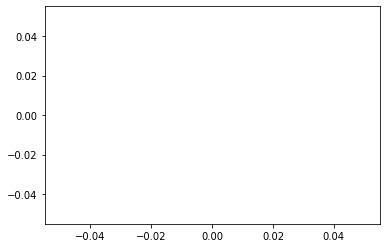

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


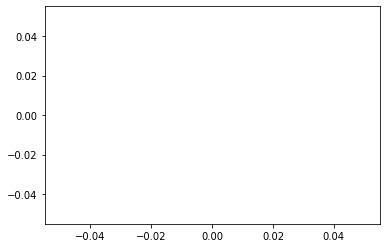

In [ ]:
#range = range(9)
sns.lineplot(range(9),diff_parm_actor)
plt.show()
sns.lineplot(range(9),diff_parm_critic)
plt.show()

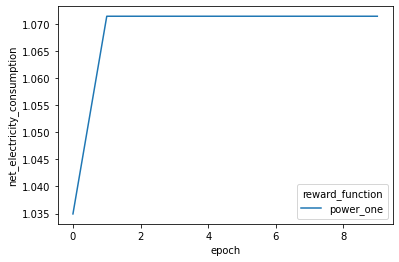

In [ ]:
df = pd.DataFrame(overall_cost)
sns.lineplot(data=df, x="epoch", y="net_electricity_consumption", hue="reward_function")

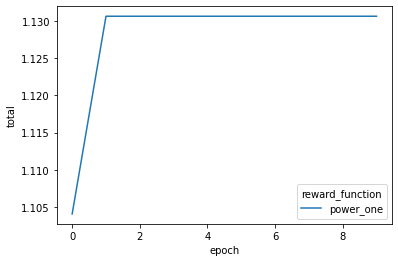

In [ ]:
df = pd.DataFrame(overall_cost)
sns.lineplot(data=df, x="epoch", y="total", hue="reward_function")